In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs
import re

In [56]:
def format_text(text):
    regex = re.compile(r'[\n\r\t]')
    text = regex.sub('', text)
    return " ".join(text.split())

In [57]:
def format_currency(value):
    value = value.replace('€', '')
    value = value.replace('-', '0')
    value = value.replace('Loan fee:', '')
    value = value.replace('-', '0')
    value = value.replace('?', '0')
    value = value.replace('loan transfer', '0')
    value = value.replace('free transfer', '0')

    if value[-1] == 'm':
        value = value.replace('m', '')
        return float(value)

    if value[-1] == '.':
        value = value.replace('.', '')
        if value[-2:] == 'Th':
            value = value.replace('Th', '')
            return float(value) / 1000
    return value

In [58]:
def loan_transform(value):
    if bool(re.match('loan', value, re.I)):
        bool_value = True
        return bool_value
    else:
        bool_value = False
        return bool_value

In [59]:
def get_data(pages):
    players_list = []
    for page in range(0, pages+1):
        headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36"}
        url = f'https://www.transfermarkt.com/transfers/saisontransfers/statistik/top/plus/1/galerie/0?saison_id=2022&transferfenster=sommertransfers&land_id=&ausrichtung=&spielerposition_id=&altersklasse=&leihe=&page={page}'

        html = requests.get(url, headers=headers)
        soup = bs(html.content)
        soup = soup.select('.responsive-table > .grid-view > .items > tbody')[0]

        try:
            for cells in soup.find_all(True, {"class": re.compile("^(even|odd)$")}):
                fee = cells.find_all('td')[16].text
                loan = cells.find_all('td')[16].text
                position = cells.find_all('td')[4].text
                age = cells.find_all('td')[5].text
                market_value = cells.find_all('td')[6].text
                try:
                    country_from = cells.find_all('td')[11].img['title']
                except:
                    country_from = None
                    pass
                league_from = cells.find_all('td')[11].a.text if cells.find_all('td')[11].a != None else 'Without League'
                club_from = cells.find_all('td')[9].img['alt']
                country_to = cells.find_all('td')[15].img['alt']
                league_to = cells.find_all('td')[15].a.text if cells.find_all('td')[15].a != None else 'Without League'
                club_to = cells.find_all('td')[13].img['alt']

                player = {
                    'name': cells.find_all('td')[1].select('td > img')[0]['title'],
                    'position': position,
                    'age': age,
                    'market_value': format_currency(market_value),
                    'country_from': country_from,
                    'league_from': format_text(league_from),
                    'club_from': club_from,
                    'country_to': country_to,
                    'league_to': format_text(league_to),
                    'club_to': club_to,
                    'fee': format_currency(fee),
                    'loan': loan_transform(loan),
                }

                players_list.append(player)
        except IndexError:
            pass

    return players_list

In [60]:
def data_to_csv(data):
    keys = data[0].keys()
    with open('data.csv', 'w', newline='')  as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows(data)

In [61]:
data = get_data(pages=5)
df1 = pd.DataFrame(data=data)

In [62]:
df1.to_csv("transfer_market.csv")
df1["name"].to_csv("name.csv")




Using the "name.csv" file to retrieve player statistics. If the player exists on the website 'https://www.fifaratings.com', we collect their statistics. Otherwise, we assign a value of 0 to all columns to signify that the player was not found on the website. The scraped data will be stored in a CSV file named "stats.csv".




In [63]:
# reading the names from the csv file and store it in name_list
def read_names_from_csv(csv_file):
  name_list = []
  with open(csv_file, 'r') as file:    # the csv file that contains names is names.csv
    next(file)
    k = 0
    for line in file:
      name_list.append(line.split(',')[1].replace(' ', '-').replace('\n', ''))
  return name_list

In [64]:
# scrapping the values from the website

def scrape_player_data(name_list):
  player_not_found = []
  skills_stat = []


  for name in name_list:
    url = f"https://www.fifaratings.com/{name}"
    html_text = requests.get(url, headers={'user-agent':"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0"}).text
    soup = bs(html_text, "lxml")

    players = soup.find_all("span", class_ = "mr-n1")
    temp = []
    for item in players:
        temp.append(item.text)

    if temp == []:
        player_not_found.append(name)
    else:
        skills_stat.append(temp)
  return skills_stat, player_not_found

In [65]:
# removing the uneccessary values from skills_stat

def clean_player_data(skills_stat):
  index_to_remove = [2 * i + 1 for i in range(8)]


  for item in skills_stat:
    for index in sorted(index_to_remove, reverse=True):
        del item[index]
    del item[-1]
  return skills_stat

In [66]:
# combining skill_name and skills_stat

def combine_data(name_list, skills_stat, player_not_found):
    data = []
    columns = ["ATT", "SKI", "MOV", "POW", "MEN", "DEF", "GK"]  # the skills that we want to scrap

    for i, name in enumerate(name_list):
        player = {}
        if name in player_not_found:
            player["name"] = name.replace('-', ' ')
            for column in columns:
                player[column] = np.nan
        else:
          if i < len(skills_stat):
            player["name"] = name.replace('-', ' ')
            for index, column in enumerate(columns):
                player[column] = skills_stat[i][index]
        data.append(player)

    return data

In [67]:
def save_to_csv(data, output_csv_file):
    fields = data[0].keys()

    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

In [68]:
import csv
def read_names_from_csv(csv_file):
    name_list = []
    with open(csv_file, 'r', encoding='utf-8', errors='ignore') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  
        for row in csv_reader:
            name_list.append(row[0]) 
    return name_list
def save_to_csv(data, output_csv_file):
    with open(output_csv_file, 'w', newline='', encoding='utf-8') as file:
        csv_writer = csv.writer(file)
        csv_writer.writerow(['Name', 'Skill1', 'Skill2', 'Skill3'])  # Assuming these are the column headers
        for item in data:
            csv_writer.writerow([item['name'], item['skill1'], item['skill2'], item['skill3']])  # Adjust this based on your data structure
csv_file = 'name.csv'
output_csv_file = 'stats.csv'
name_list = read_names_from_csv(csv_file)
skills_stat, player_not_found = scrape_player_data(name_list)
clean_player_data(skills_stat)
data = combine_data(name_list, skills_stat, player_not_found)

save_to_csv(data, output_csv_file)


So far, we have gathered two types of data. Now, it's time to merge all the collected data and begin the cleaning process.

In [ ]:
df1.head()

,name,position,age,market_value,country_from,league_from,club_from,country_to,league_to,club_to,fee,loan
0,Erling Haaland,Centre-Forward,21,150.0,Germany,Bundesliga,Borussia Dortmund,England,Premier League,Manchester City,60.0,False
1,Antony,Right Winger,22,35.0,Netherlands,Eredivisie,Ajax Amsterdam,England,Premier League,Manchester United,95.0,False
2,Wesley Fofana,Centre-Back,21,40.0,England,Premier League,Leicester City,England,Premier League,Chelsea FC,80.4,False
3,Aurélien Tchouaméni,Defensive Midfield,22,60.0,Monaco,Ligue 1,AS Monaco,Spain,LaLiga,Real Madrid,80.0,False
4,Casemiro,Defensive Midfield,30,40.0,Spain,LaLiga,Real Madrid,England,Premier League,Manchester United,70.65,False


In [ ]:
df2 = pd.read_csv('stats.csv')
df2.head()

,name,ATT,SKI,MOV,POW,MEN,DEF,GK
0,Erling Haaland,76.0,70.0,82.0,86.0,75.0,42.0,10.0
1,Antony,54.0,63.0,66.0,51.0,49.0,42.0,11.0
2,Wesley Fofana,50.0,54.0,69.0,62.0,62.0,80.0,11.0
3,Aurélien Tchouaméni,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df1.merge(df2, on = "name")
df.head()

,name,position,age,market_value,country_from,league_from,club_from,country_to,league_to,club_to,fee,loan,ATT,SKI,MOV,POW,MEN,DEF,GK
0,Erling Haaland,Centre-Forward,21,150.0,Germany,Bundesliga,Borussia Dortmund,England,Premier League,Manchester City,60.0,False,76.0,70.0,82.0,86.0,75.0,42.0,10.0
1,Antony,Right Winger,22,35.0,Netherlands,Eredivisie,Ajax Amsterdam,England,Premier League,Manchester United,95.0,False,54.0,63.0,66.0,51.0,49.0,42.0,11.0
2,Wesley Fofana,Centre-Back,21,40.0,England,Premier League,Leicester City,England,Premier League,Chelsea FC,80.4,False,50.0,54.0,69.0,62.0,62.0,80.0,11.0
3,Aurélien Tchouaméni,Defensive Midfield,22,60.0,Monaco,Ligue 1,AS Monaco,Spain,LaLiga,Real Madrid,80.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Casemiro,Defensive Midfield,30,40.0,Spain,LaLiga,Real Madrid,England,Premier League,Manchester United,70.65,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          20 non-null     object 
 1   position      20 non-null     object 
 2   age           20 non-null     object 
 3   market_value  20 non-null     float64
 4   country_from  20 non-null     object 
 5   league_from   20 non-null     object 
 6   club_from     20 non-null     object 
 7   country_to    20 non-null     object 
 8   league_to     20 non-null     object 
 9   club_to       20 non-null     object 
 10  fee           20 non-null     object 
 11  loan          20 non-null     bool   
 12  ATT           10 non-null     float64
 13  SKI           10 non-null     float64
 14  MOV           10 non-null     float64
 15  POW           10 non-null     float64
 16  MEN           10 non-null     float64
 17  DEF           10 non-null     float64
 18  GK            10 non-null     fl

In [ ]:
df.isnull().sum()

name             0
position         0
age              0
market_value     0
country_from     0
league_from      0
club_from        0
country_to       0
league_to        0
club_to          0
fee              0
loan             0
ATT             10
SKI             10
MOV             10
POW             10
MEN             10
DEF             10
GK              10
dtype: int64

In [ ]:
dataF = df.copy()
dataF = dataF.dropna()
dataF.head()

,name,position,age,market_value,country_from,league_from,club_from,country_to,league_to,club_to,fee,loan,ATT,SKI,MOV,POW,MEN,DEF,GK
0,Erling Haaland,Centre-Forward,21,150.0,Germany,Bundesliga,Borussia Dortmund,England,Premier League,Manchester City,60.0,False,76.0,70.0,82.0,86.0,75.0,42.0,10.0
1,Antony,Right Winger,22,35.0,Netherlands,Eredivisie,Ajax Amsterdam,England,Premier League,Manchester United,95.0,False,54.0,63.0,66.0,51.0,49.0,42.0,11.0
2,Wesley Fofana,Centre-Back,21,40.0,England,Premier League,Leicester City,England,Premier League,Chelsea FC,80.4,False,50.0,54.0,69.0,62.0,62.0,80.0,11.0
5,Alexander Isak,Centre-Forward,22,30.0,Spain,LaLiga,Real Sociedad,England,Premier League,Newcastle United,70.0,False,71.0,78.0,92.0,72.0,68.0,49.0,13.0
6,Matthijs de Ligt,Centre-Back,22,70.0,Italy,Serie A,Juventus FC,Germany,Bundesliga,Bayern Munich,67.0,False,81.0,75.0,71.0,80.0,72.0,34.0,11.0


In [ ]:
dataF.describe()

,market_value,ATT,SKI,MOV,POW,MEN,DEF,GK
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,60.600000,69.000000,70.000000,76.300000,73.400000,69.200000,57.500000,10.500000
std,35.768391,11.652372,9.128709,7.761014,11.007068,9.126275,21.459264,1.080123
min,28.000000,50.000000,54.000000,66.000000,51.000000,49.000000,32.000000,9.000000
25%,36.250000,61.750000,64.750000,71.000000,67.500000,64.250000,42.000000,10.000000
50%,56.500000,69.500000,73.000000,76.000000,76.000000,73.000000,49.500000,10.000000
75%,70.000000,76.750000,75.000000,80.500000,80.000000,74.000000,79.750000,11.000000
max,150.000000,86.000000,82.000000,92.000000,86.000000,81.000000,86.000000,13.000000


In [ ]:
dataF['fee'] = dataF['fee'].astype(float)
dataF['age'] = dataF['age'].astype(int)
dataF.info()

NameError: name 'dataF' is not defined

In [ ]:
dataF['loan_map'] = dataF['loan'].map({False: 0, True: 1})
dataF.head()

NameError: name 'dataF' is not defined

In [ ]:
dataF.shape

NameError: name 'dataF' is not defined

In [ ]:
def create_value_dict(column, value, other_value=0):
  dico = {value: 1}
  for line in column:
    if line != value:
      dico[line] = other_value
  return dico

In [ ]:
n = len(dataF.groupby("position")['age'].sum().keys())

for index in range(n):
  pos = dataF.groupby("position")['age'].sum().keys()[index]
  dataF[f"{pos}_position"] = dataF["position"].map(create_value_dict(dataF["position"], pos))

In [ ]:
for column in dataF.iloc[:, 4: 9].columns:
  n = len(dataF.groupby(column)['age'].sum().keys())

  for index in range(n):
    country = dataF.groupby(column)['age'].sum().keys()[index]
    dataF[f"{country}_{column}"] = dataF[column].map(create_value_dict(dataF[column], country))

<ipython-input-144-aa0d029f8301>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataF.corr().round(2)


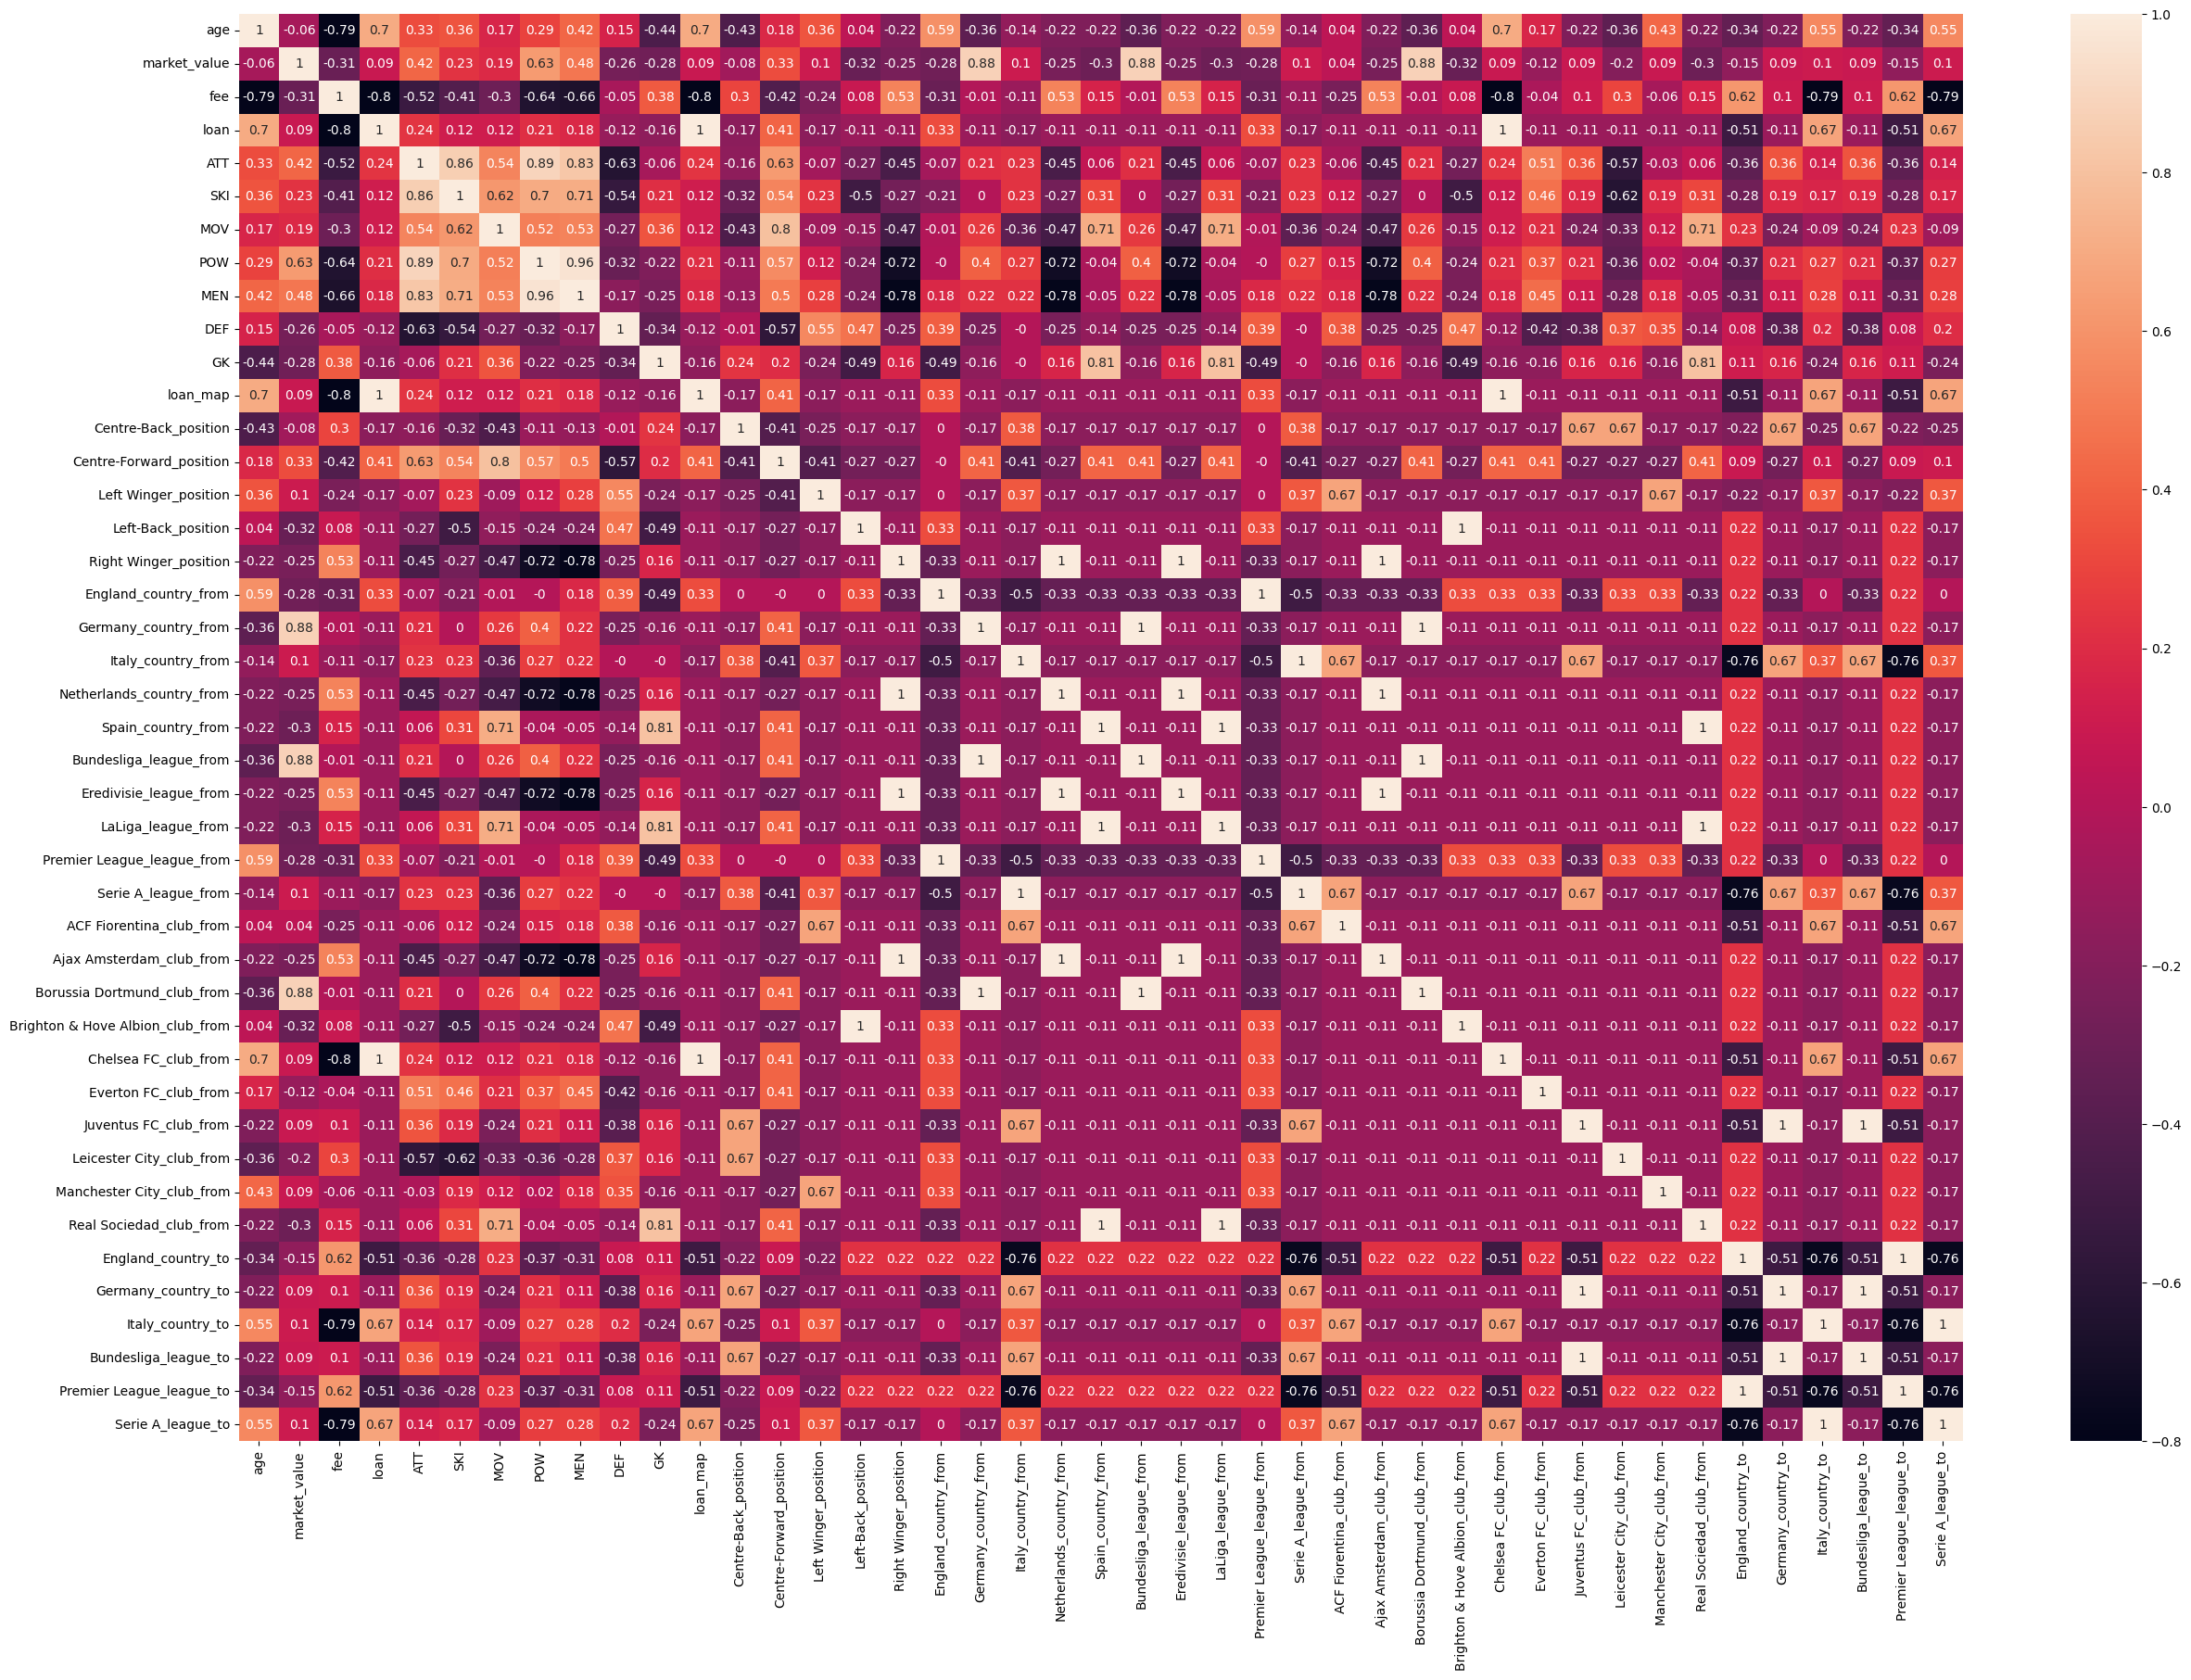

In [ ]:
corr_matrix = dataF.corr().round(2)
plt.figure(figsize=(30, 20))
plot = sns.heatmap(corr_matrix, annot=True)

In [ ]:
df.shape

(20, 19)